In [2]:
import numpy as np
import os, shutil
import cv2
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torchvision import transforms as T

C:\Users\Andaman\AppData\Local\Temp\ipykernel_22564\1835756201.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
img.shape[1]/2

512.0

NameError: name 'asdas' is not defined

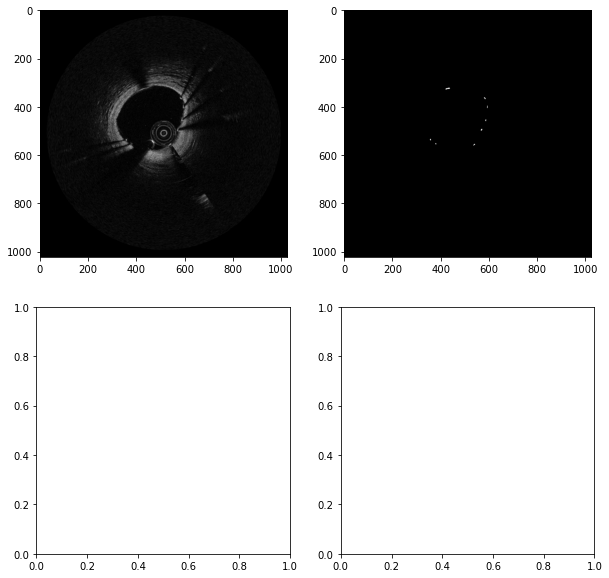

In [3]:
image_path = 'stent_dataset/train/image/b008_2_045.bmp'
label_path = image_path.replace('image', 'mask')

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)/255
label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)/255

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(label, cmap='gray')

radius = img.shape[0]/2 - np.where(img[512,:] > 0)[0][0]
value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))

polar_image = cv2.linearPolar(img, (img.shape[0]/2, img.shape[1]/2), radius, cv2.WARP_FILL_OUTLIERS)
polar_label = cv2.linearPolar(label, (img.shape[0]/2, img.shape[1]/2), radius, cv2.WARP_FILL_OUTLIERS)

ax[1,0].imshow(polar_image.transpose(1,0), cmap='gray')
ax[1,1].imshow(polar_label.transpose(1,0), cmap='gray')
plt.show()

# Convert Cartesian to Polar Images

In [ ]:
import cv2
import numpy as np
import os

In [ ]:
dataset_folder = 'stent_dataset'
save_dir = 'polar_stent_dataset'

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    print('Removed Saved Directory')

# radius = img.shape[0]/2 - np.where(img[512,:] > 0)[0][0]
radius = 484

for phase in os.listdir(dataset_folder):
    phase_folder = os.path.join(dataset_folder, phase)
    
    for data_type in os.listdir(phase_folder):
        sub_folder = os.path.join(phase_folder, data_type)
        os.makedirs(sub_folder.replace(dataset_folder, save_dir), exist_ok=True)
        
        for image_name in os.listdir(sub_folder):
            image_path = os.path.join(sub_folder, image_name)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            polar_image = cv2.linearPolar(img, (img.shape[0]/2, img.shape[1]/2), radius, cv2.WARP_FILL_OUTLIERS).transpose(1,0)
            cv2.imwrite(image_path.replace(dataset_folder, save_dir), (polar_image).astype(np.uint8))
            

# Import Trained Models

In [3]:
def try_load_weight(model, model_name, checkpoint):
    weight_key = [key for key in list(checkpoint.keys()) if 'state_dict' in key and 'model' in key][0]
    try:
        print(f'Loading {model_name} weights')
        model.load_state_dict(checkpoint[weight_key])
    except:
        print("My Model : Need DataParallel")
        model = nn.DataParallel(model)
        model.load_state_dict(checkpoint[weight_key])
    print('==============================================================================')
    model = model.cuda()
    model = model.eval()

In [4]:
for model_type in os.listdir('results/'):
    print(f"==============={model_type}===============")
    for m in os.listdir(f"results/{model_type}"):
        print(m)

===============DoubleUNet===============
DoubleUNet_test
===============ResUNet===============
ResUNet-baseline
ResUNet-PReLU
ResUNet-t2
===============ResUNetMultiConnection===============
ResUNetMC-baseline
sample_w_1-10
===============UNet===============
baseline
UNet-64F
UNet-PReLU-Cond-512P
UNet-PReLU-Cond-512P-64F
===============UNetMultiConnection===============
UNetMC
UNetMC-CondCrop-512P
UNetMC-PReLU-Cond-512P
UNetMC-ReLU-Cond-512P


In [5]:
import my_network.network as network
from my_network.UNetMultiConnection import UNetMultiConnection
from my_network.DoubleUNet import DoubleUNet
from my_network.UNet import UNet
from my_network.CustomUNet import CustomUNet
from my_network.ResUNet import ResUNet
from my_network.ResUNetMultiConnection import ResUNetMultiConnection
import torch
from torch import nn


num_img_ch = 1
num_classes = 2
num_features = 32

model_path_list = [
                   'ResUNet/ResUNet-baseline',
                   'ResUNetMultiConnection/ResUNetMC-baseline',
                   'UNetMultiConnection/UNetMC-PReLU-Cond-512P',
                   'UNet/UNet-PReLU-Cond-512P'
                  ]
checkpoint_list = [torch.load(f'results/{model_path}/model.pth', map_location='cuda') for model_path in model_path_list]


models_list = []
models_type_list = []
for i, model_path in enumerate(model_path_list):
    model_type = model_path.split('/')[0]
    
#     if i == 1:
#         model_type = 'CustomUNet'
    
#     if model_type == 'UNet':
#         models_list.append(UNet(in_channels=checkpoint_list[i]['config'].num_img_ch,
#                                 out_channels=checkpoint_list[i]['config'].num_classes,
#                                 num_features=checkpoint_list[i]['config'].num_features))
    if model_type == 'UNet':
        models_list.append(CustomUNet(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                      out_channels=checkpoint_list[i]['config'].num_classes,
                                      num_features=checkpoint_list[i]['config'].num_features))
    elif model_type == 'UNetMultiConnection':
        models_list.append(UNetMultiConnection(in_channels=1,
                                               out_channels=2,
                                               num_features=32))
    elif model_type == 'DoubleUNet':
        models_list.append(DoubleUNet(in_channels=1, freeze_vgg=True))
    elif model_type == 'ResUNet':
        models_list.append(ResUNet(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                   out_channels=checkpoint_list[i]['config'].num_classes,
                                   num_features=checkpoint_list[i]['config'].num_features))
    elif model_type =='ResUNetMultiConnection':
        models_list.append(ResUNetMultiConnection(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                                  out_channels=checkpoint_list[i]['config'].num_classes,
                                                  num_features=checkpoint_list[i]['config'].num_features))
    else:
        raise NotImplementedError(f"Model {model_type} is not implemented")
    
    try_load_weight(models_list[i], model_type, checkpoint_list[i])
    models_type_list.append(model_type)




# Load Baseline Model
baseline_checkpoint = torch.load('results/UNet/baseline/model.pth')
baseline_model = network.UNet(in_channels=baseline_checkpoint['config'].num_img_ch,
                              out_channels=baseline_checkpoint['config'].num_classes,
                              num_features=baseline_checkpoint['config'].num_features)
try:
    print(f'Loading Baseline UNet weights')
    baseline_model.load_state_dict(baseline_checkpoint['model_UNet_state_dict'])
except:
    print("Baseline : Need DataParallel")
    baseline_model = nn.DataParallel(baseline_model)
    baseline_model.load_state_dict(baseline_checkpoint['model_UNet_state_dict'])
baseline_model.eval()
baseline_model.cuda()



print('Passed')
print('...')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Baseline model has {count_parameters(baseline_model):,} trainable parameters')
for i, model in enumerate(models_list):
    print(f'Model {models_type_list[i]:30}: {count_parameters(model):10,} trainable parameters')

Loading ResUNet weights
My Model : Need DataParallel
Loading ResUNetMultiConnection weights
My Model : Need DataParallel
Loading UNetMultiConnection weights
My Model : Need DataParallel
Loading UNet weights
My Model : Need DataParallel
Loading Baseline UNet weights
Baseline : Need DataParallel
Passed
...
Baseline model has 232,162 trainable parameters
Model ResUNet                       : 11,576,655 trainable parameters
Model ResUNetMultiConnection        : 11,705,679 trainable parameters
Model UNetMultiConnection           :    676,567 trainable parameters
Model UNet                          :    232,184 trainable parameters


# Save Temp. Figures

In [ ]:
image_list = sorted(os.listdir('polar_stent_dataset/image/test'))
test_plot = False
th = 0.5

if os.path.exists('figures'):
    shutil.rmtree('figures')
os.makedirs('figures')


for index, image_name in tqdm(enumerate(image_list), total=len(image_list)):
    image = Image.open(f'polar_stent_dataset/image/test/{image_name}')
    image = np.array(image).astype(np.float32) / 255.0
    image = image / np.std(image)
    image = T.ToTensor()(np.array(image))
    
    label = Image.open(f'polar_stent_dataset/label/test/{image_name}')
    label = np.array(label).astype(np.float32) / 255.0
    label = T.ToTensor()(np.array(label))
    
    image = image.to('cuda')
    baseline_output = baseline_model(image.unsqueeze(0))[0][1].detach().cpu().numpy()
    th_dice_baseline = get_similiarity(T.ToTensor()(np.where(baseline_output > th, 1, 0)), label).item()
    
    outputs = []
    th_dice_score = []
    for model in models_list:
        pred = model(image.unsqueeze(0))[0][1].detach().cpu().numpy()
        th_pred = np.where(pred > th, 1, 0)
        tensor_th_pred = T.ToTensor()(th_pred)
        outputs.append(th_pred)
        th_dice_score.append(get_similiarity(tensor_th_pred, label).item())
#     output1 = my_model1(image.unsqueeze(0))[0][1].detach().cpu().numpy()
#     output2 = my_model2(image.unsqueeze(0))[0][1].detach().cpu().numpy()
    
    fig, ax = plt.subplots(1,5,figsize=(30,30))
    ax[0].imshow(image[0].detach().cpu().numpy(), cmap='gray')
    ax[1].imshow(np.where(baseline_output > th, 1, 0),)
    ax[2].imshow(np.where(outputs[0] > th, 1, 0),)
    ax[3].imshow(np.where(outputs[1] > th, 1, 0),)
    ax[4].imshow(label[0].detach().cpu().numpy(),)
    
    font_size = 27
    ax[1].text(30, 60,'Baseline (UNet)', fontsize=font_size, color='red')
    ax[1].text(30, 1000,f'Dice: {th_dice_baseline:.4f}', fontsize=font_size, color='white')
    
    ax[2].text(30, 60,f'{models_type_list[0]}', fontsize=font_size, color='red')
    ax[2].text(30, 1000,f'Dice: {th_dice_score[0]:.4f}', fontsize=font_size, color='white')
    
    ax[3].text(30, 60,f'{models_type_list[1]}', fontsize=font_size, color='red')
    ax[3].text(30, 1000,f'Dice: {th_dice_score[1]:.4f}', fontsize=font_size, color='white')
    
    ax[4].text(30, 60,'Target', fontsize=font_size, color='red')
        
    fig.set_dpi(300)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    
    for axis in ax:
        axis.axis('off')
        
    if test_plot:
        plt.show()
        break
    
    fig.savefig(f'figures/{index}.png')
    plt.clf()
    plt.close('all')


# Write Video

In [ ]:
image.shape

In [ ]:
# Write a video from the saved plots
save_vdo_name = '3 Models_5FPS'
padding = 30
image_list_for_vdo = os.listdir('figures')

size = (2160, 475)
writer = cv2.VideoWriter(f'Videos/{save_vdo_name}.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)

for index in tqdm(range(len(image_list_for_vdo))):
    image_path = f"figures/{index}.png"
    image = cv2.imread(image_path)
    image = image[872-padding:1287+padding,:,:]
    
    if index == 0:
        image_shape = image.shape[1], image.shape[0]
        assert size == image_shape, "Size Mismatch"
    
    writer.write(image)

writer.release()
print(f'Saved the video at /Videos/{save_vdo_name}.mp4')

# Make .gif

In [ ]:
import imageio
 
cap = cv2.VideoCapture('Videos/3 Models.mp4')
image_lst = []
 
while True:
    ret, frame = cap.read()
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_lst.append(frame_rgb)
    
    cv2.imshow('a', frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
 
# Convert to gif using the imageio.mimsave method
imageio.mimsave('Videos/3 Models.gif', image_lst, fps=60)

In [ ]:
label = Image.open(f'dataset/label/test/{image_name}')
label = np.array(label).astype(np.float32) / 255.0
label = T.ToTensor()(np.array(label))
label.shape

In [ ]:
imageio.mimsave('Videos/3 Models.gif', image_lst, fps=20)

In [ ]:
shutil.rmtree('figures')